<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_11b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Displacements
  1.0000       0.0000
  2.0000       0.6857
  3.0000       2.2689
  4.0000       4.0387
  5.0000       5.2843
  6.0000       5.0645
  7.0000       4.8447
  8.0000       4.6249
  9.0000       4.4052
 10.0000       3.2197
 11.0000       1.7606
 12.0000       0.5226
 13.0000       0.0000
 14.0000       0.0000
 15.0000       0.1630
 16.0000       0.3261
 17.0000       0.4891
 18.0000       0.6522
 19.0000       0.1942
 20.0000       0.0687
 21.0000      -0.0912
 22.0000      -0.6522
 23.0000      -0.4891
 24.0000      -0.3261
 25.0000      -0.1630
 26.0000       0.0000
 27.0000       0.0000
 28.0000      -0.0008
 29.0000      -0.0012
 30.0000      -0.0011
 31.0000      -0.0005
 32.0000      -0.0002
 33.0000      -0.0001
 34.0000      -0.0002
 35.0000      -0.0006
 36.0000      -0.0009
 37.0000      -0.0010
 38.0000      -0.0006
 39.0000       0.0000

reactions
  1.0000   -8846.1538
 13.0000   -6153.8462
 14.0000   -4565.2174
 26.0000    4565.2174
 27.0000 30022296.5440
 39.00

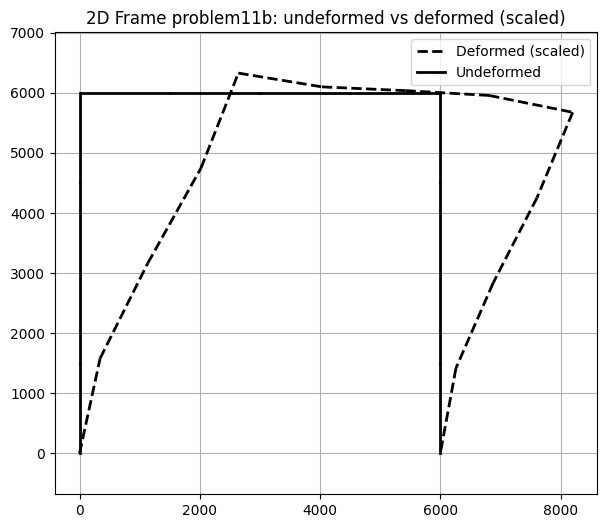

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2D FRAME (problem11b.m) - FIXED NODE ORDER
# DOF order matches MATLAB:
#   [u1..un, v1..vn, theta1..thetan]
# ============================================================

def solution(GDof, prescribedDof, K, F):
    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)  # 0-based
    all_dofs = np.arange(GDof)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof)
    K_ff = K[np.ix_(free, free)]
    F_f  = F[free]
    U[free] = np.linalg.solve(K_ff, F_f)
    return U


def outputDisplacementsReactions(U, K, F, prescribedDof):
    R = K @ U - F

    print("Displacements")
    for i, ui in enumerate(U, start=1):
        print(f"{i:8.4f} {ui:12.4f}")

    print("\nreactions")
    # MATLAB prints reactions only at prescribed dof (and scales in display sometimes).
    # We'll print them directly.
    for d in prescribedDof:
        print(f"{d:8.4f} {R[d-1]:12.4f}")


def formStiffness2Dframe(GDof, numberElements, elementNodes, numberNodes, xx, yy, EI, EA):
    K = np.zeros((GDof, GDof))

    for e in range(numberElements):
        i, j = int(elementNodes[e, 0]), int(elementNodes[e, 1])  # 1-based

        # elementDof = [i j i+n j+n i+2n j+2n] (MATLAB indexing)
        edof = np.array([
            i-1, j-1,
            (i-1)+numberNodes, (j-1)+numberNodes,
            (i-1)+2*numberNodes, (j-1)+2*numberNodes
        ], dtype=int)

        xa = xx[j-1] - xx[i-1]
        ya = yy[j-1] - yy[i-1]
        L  = np.sqrt(xa*xa + ya*ya)

        c = xa / L
        s = ya / L

        # Transformation matrix (same structure as in your MATLAB snippet)
        T = np.block([
            [ c*np.eye(2),  s*np.eye(2), np.zeros((2,2)) ],
            [-s*np.eye(2),  c*np.eye(2), np.zeros((2,2)) ],
            [ np.zeros((2,4)), np.eye(2) ]
        ])

        oneu  = np.array([[ 1, -1],
                          [-1,  1]], dtype=float)
        oneu2 = oneu.copy()
        oneu3 = np.array([[ 1,  1],
                          [-1, -1]], dtype=float)
        oneu4 = np.array([[4, 2],
                          [2, 4]], dtype=float)

        k_local = np.block([
            [ EA/L * oneu,                 np.zeros((2,2)),                  np.zeros((2,2)) ],
            [ np.zeros((2,2)), 12*EI/L**3 * oneu2,        6*EI/L**2 * oneu3 ],
            [ np.zeros((2,2)),  6*EI/L**2 * oneu3.T,      EI/L * oneu4     ]
        ])

        K[np.ix_(edof, edof)] += T.T @ k_local @ T

    return K


def drawingMesh(nodeCoordinates, elementNodes, style='k--', label=None):
    for (n1, n2) in elementNodes:
        x = [nodeCoordinates[n1-1, 0], nodeCoordinates[n2-1, 0]]
        y = [nodeCoordinates[n1-1, 1], nodeCoordinates[n2-1, 1]]
        plt.plot(x, y, style, linewidth=2, label=label)
        label = None


# ============================================================
# MAIN (problem11b.m)  --- FIXED NODE ORDER HERE
# ============================================================

E = 210000.0
A = 200.0
I = 2e8
EA = E * A
EI = E * I

numberElements = 12

# IMPORTANT: Node order must follow MATLAB list (perimeter path):
# left column bottom->top, top beam left->right, right column top->bottom
nodeCoordinates = np.array([
    [0.0,    0.0],     # 1
    [0.0, 1500.0],     # 2
    [0.0, 3000.0],     # 3
    [0.0, 4500.0],     # 4
    [0.0, 6000.0],     # 5
    [1500.0, 6000.0],  # 6
    [3000.0, 6000.0],  # 7
    [4500.0, 6000.0],  # 8
    [6000.0, 6000.0],  # 9
    [6000.0, 4500.0],  # 10
    [6000.0, 3000.0],  # 11
    [6000.0, 1500.0],  # 12
    [6000.0,    0.0],  # 13
], dtype=float)

numberNodes = nodeCoordinates.shape[0]
xx = nodeCoordinates[:, 0]
yy = nodeCoordinates[:, 1]

# elementNodes(i,:)=[i i+1]
elementNodes = np.column_stack([np.arange(1, numberElements+1),
                                np.arange(2, numberElements+2)]).astype(int)

GDof = 3 * numberNodes
F = np.zeros(GDof)

# Loads exactly as MATLAB:
# force(5)=15000;
# force(31)=10e6;
F[4]  = 15000.0   # DOF 5
F[30] = 10e6      # DOF 31

# Stiffness
K = formStiffness2Dframe(GDof, numberElements, elementNodes, numberNodes, xx, yy, EI, EA)

# Prescribed dof exactly as MATLAB:
prescribedDof = [1, 13, 14, 26, 27, 39]

# Solve
U = solution(GDof, prescribedDof, K, F)

# Output (format gần giống MATLAB)
outputDisplacementsReactions(U, K, F, prescribedDof)

# Plot undeformed + deformed (MATLAB scale 500)
scale = 500.0
Ux = U[0:numberNodes]
Uy = U[numberNodes:2*numberNodes]
deformed = nodeCoordinates + scale * np.column_stack([Ux, Uy])

plt.figure(figsize=(7,6))
plt.axis('equal')
plt.grid(True)
plt.title("2D Frame problem11b: undeformed vs deformed (scaled)")
drawingMesh(deformed, elementNodes, style='k--', label='Deformed (scaled)')
drawingMesh(nodeCoordinates, elementNodes, style='k-', label='Undeformed')
plt.legend()
plt.show()
